# A/B testing & Hypothesis Testing 

**Contents**

## About Dataset : Marketing A/B testing dataset

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:
- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

Link : https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

## Working Process
1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
5. Check Normality & Homogeneity
6. Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
7. Evaluate the results
8. Make inferences
9. Recommend business decision to your customer/director/ceo etc.

### 1. PACKAGES

In [2]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

### 2. DATA

In [3]:
def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read

In [4]:
path = '/Users/crystal/Desktop/A:B Testing /marketing_AB.csv'    
df = load(path, info = True)
df.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 588101 Column: 7 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 2 
 ['test group', 'most ads day'] 

Integer Variables: 
 # of Variables: 4 
 ['Unnamed: 0', 'user id', 'total ads', 'most ads hour'] 

Bool Variables: 
 # of Variables: 1 
 ['converted'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 27.5+ MB


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### 3. SUMMARY STATS

In [7]:
# Number of Unique User
print(df['user id'].nunique() == df.shape[0])

True


In [9]:
# A/B Groups & Target Summary Stats
df.groupby("test group")['most ads hour'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
test group,,,,,
ad,564577,14.0000,14.4759,4.8418,23
psa,23524,14.0000,14.3049,4.6562,23


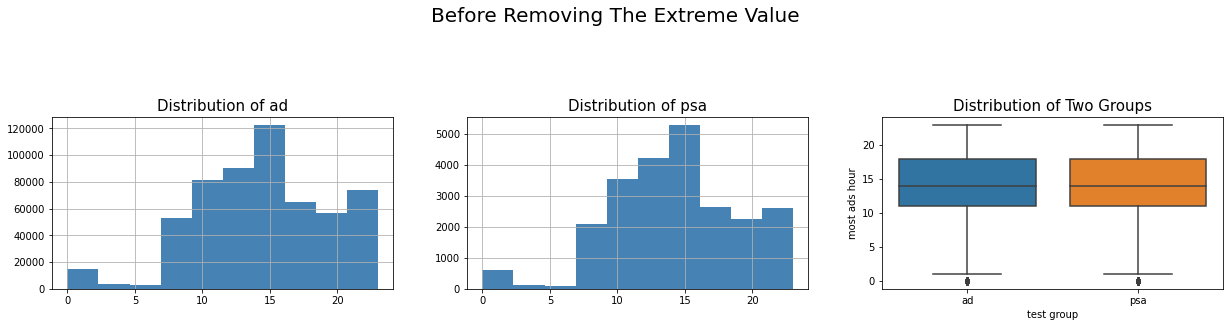

In [14]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
df[(df["test group"] == "ad")].hist('most ads hour', ax = axes[0], color = "steelblue")
df[(df["test group"] == "psa")].hist('most ads hour', ax = axes[1], color = "steelblue")
sns.boxplot(x = df["test group"], y = df['most ads hour'], ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of ad", fontsize = 15)
axes[1].set_title("Distribution of psa", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

Text(0.5, 0.98, 'Before Removing The Extreme Value')

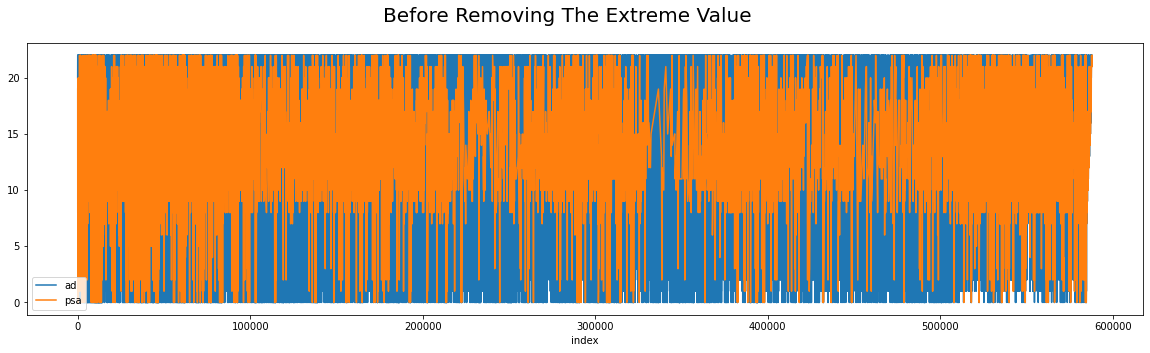

In [18]:
df[(df["test group"] == "ad")].reset_index().set_index("index")['most ads hour'].plot(legend = True, label = "ad", figsize = (20,5))
df[(df["test group"] == "psa")].reset_index().set_index("index")['most ads hour'].plot(legend = True, label = "psa")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20)

### 4. OUTLIERS

In [17]:
df = df[df['most ads hour'] < df['most ads hour'].max()]

# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["most ads hour"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
most ads hour,567935.0000,14.1661,4.6398,0.0000,1.0000,8.0000,9.0000,10.0000,14.0000,19.0000,20.0000,21.0000,22.0000,22.0000


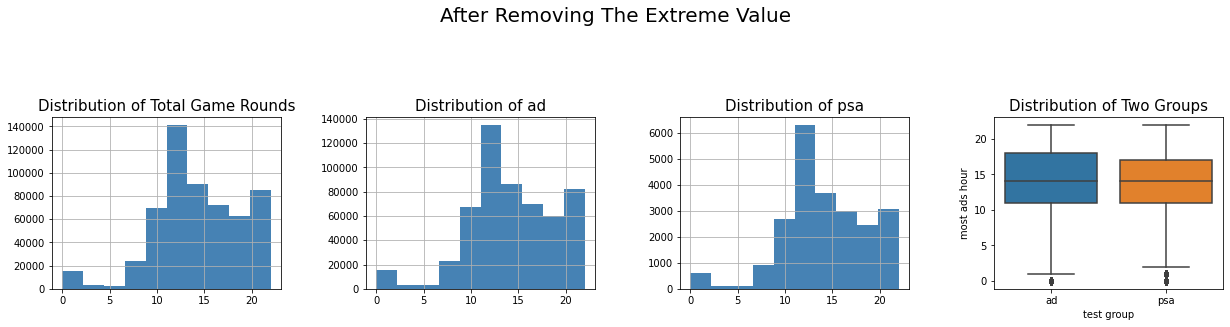

In [20]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
df['most ads hour'].hist(ax = axes[0], color = "steelblue")
df[(df["test group"] == "ad")].hist('most ads hour', ax = axes[1], color = "steelblue")
df[(df["test group"] == "psa")].hist('most ads hour', ax = axes[2], color = "steelblue")
sns.boxplot(x = df["test group"], y = df['most ads hour'], ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of ad", fontsize = 15)
axes[2].set_title("Distribution of psa", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

Text(0.5, 0.98, 'Before Removing The Extreme Value')

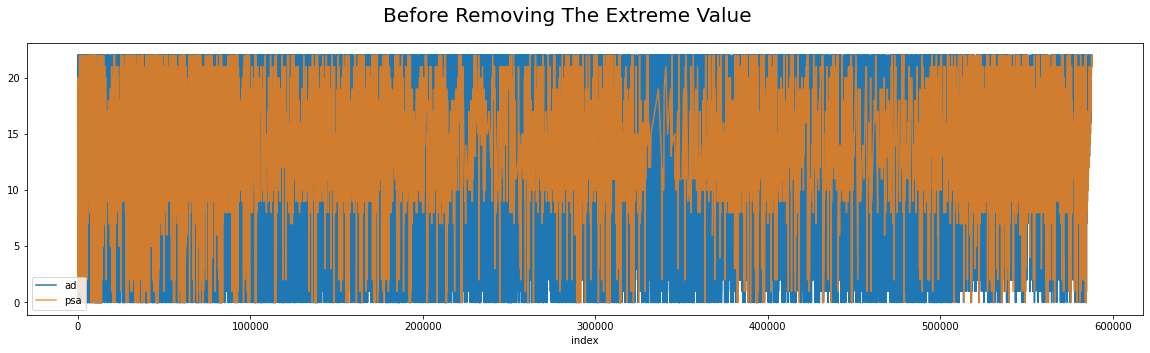

In [21]:
df[(df["test group"] == "ad")].reset_index().set_index("index")['most ads hour'].plot(legend = True, label = "ad", figsize = (20,5))
df[(df["test group"] == "psa")].reset_index().set_index("index")['most ads hour'].plot(legend = True, label = "psa",alpha = 0.8)
plt.suptitle("Before Removing The Extreme Value", fontsize = 20)